# PEC 2: Machine Learning

## Sheila Fernández Cisneros 
## Actividad
### Descripción
El uso de radiografías en el ámbito medico esta ampliamente extendido. Los radiologos son los médicos que
analizan las imágenes y redactan el informe sobre lo que ven. Desde hace algunos años, los algoritmos de
machine learning, en especial la redes neuronales artificiales, están analizando imágenes con un gran éxito.
En esta PEC se plantea la implementación de una red neuronal convolucional para clasificar radiografías en
normales o con derrame.
El conjunto de datos (ver zip) que vamos a utilizar consta de 350 radiografías de tórax normales (carpeta con
el nombre normal) y 350 radiografías con derrame (carpeta con el nombre effusion), tomadas y seleccionadas
del conjunto de datos público NIH ChestXray14:
https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publiclyavailable-chest-x-ray-datasets-scientific-community.
Como ejemplo, se presenta la imagen del fichero n99.png del grupo normal.

## Enunciado
**1. Desempaquetar y leer el fichero de datos**

Usaremos google colab para resolver esta actividad. 

Procedemos a cargar las carpetas con las imagenes, hay dos modos de hacerlo, se puede cargar directamente desde el directorio del ordenador a google colab con el inconveniente de que al abrir una nueva sesión, habría que volver a cargar el directorio, por tanto para ahorrarnos tiempo, vamos a subir nuestra carpeta de datos descomprimida a google drive y conectarlo a google colab para acceder directamente.

Primer método que no usaremos:

from google.colab import files uploaded = files.upload()

A continuación seleccionas el archivo que desear subir.

Al ser un archivo zip debemos descomprimirlo:

import zipfile import io data = zipfile.ZipFile(io.BytesIO(uploaded["archivo.zip"], "r") data.extractall()

Para conectar google colab y google drive, se puede usar el código que detallo a continuación:


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Procedemos a ver en que carpeta estamos dentro de google colab y comprobamos que nos encontramos en /content. En el menú izquierdo de google colab podemos acceder a /content y de ahí poder acceder a las carpetas que necesitemos. 

In [ ]:
!pwd

/content


En este caso, los datos se encuentran en una carpeta llamada data la cual contiene las carpetas normal y effusion. Estas son las rutas de las carpetas:

In [ ]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/data"
n_path = "/content/drive/MyDrive/Colab_Notebooks/data/normal"
e_path = "/content/drive/MyDrive/Colab_Notebooks/data/effusion"

#### Referencias: 
Esta información la he aprendido gracias a este recurso de youtube: 

https://www.youtube.com/watch?v=fJvAgRTH488

### 2. Presentar algunas imágenes de radiografías normales y con derrame.

En primer lugar, procedemos a cargar las librerías que vamos a usar. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, ZeroPadding2D, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve


In [ ]:
dir = "/content/drive/MyDrive/Colab_Notebooks/"
ruta_imagen = dir + "data" 
ruta_normal = os.path.join(ruta_imagen + '/normal')
ruta_effusion = os.path.join(ruta_imagen + '/effusion')


In [ ]:
print("Total number of normal images in training set: ",len(os.listdir(ruta_normal)))
print("Total number of effusion images in training set: ",len(os.listdir(ruta_effusion)))

Total number of normal images in training set:  350
Total number of effusion images in training set:  350


Observamos que tenemos 350 imagenes en la carpeta de radiografías normales y 350 en la carpeta de radiografías effusion.

Mostramos un par de imágenes de radiografías normales: 

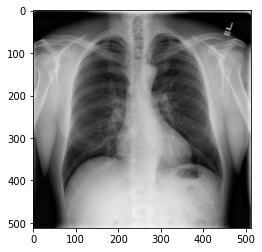

(512, 512, 3)


In [ ]:
# Importamos las librerias openCV, matplotlib
import cv2
import matplotlib.pyplot as plt

# Cargar la imagen con openCV
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/data/normal/n1.png')
# Mostramos la imagen número 1 de la carpeta normal
plt.imshow(img)
plt.show()
print(img.shape)

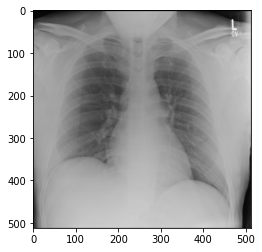

(512, 512, 3)


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/data/normal/n23.png')
# Mostramos la imagen número 23 de la carpeta normal
plt.imshow(img)
plt.show()
print(img.shape)

Mostramos un par de imágenes de la carpeta effusion, radiografías de pulmones con derrame: 

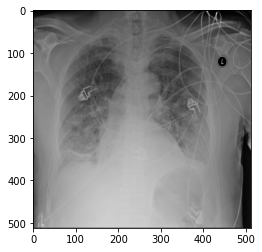

(512, 512, 3)


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/data/effusion/e1.png')
# Mostramos la imagen número 1 de la carpeta effusion
plt.imshow(img)
plt.show()
print(img.shape)

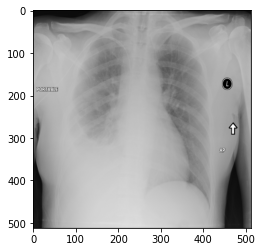

(512, 512, 3)


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/data/effusion/e11.png')
# Mostramos la imagen número 11 de la carpeta effusion
plt.imshow(img)
plt.show()
print(img.shape)

Comprobamos con la función shape que las imágenes presentan dimensiones de 512x512 y canal 3. 

## Referencias usadas para realizar esta parte de la actividad: 

https://www.youtube.com/watch?v=fJvAgRTH488

https://colab.research.google.com/drive/1qVdz2ClR9x2Ig7IezGSnw1K8qhBGRoGU?usp=sharing

https://noemioocc.github.io/posts/Mostrar-varias-im%C3%A1genes-con-matplotlib/





### 3. Preprocesar las imágenes originales de 512x512x3 para convertirlas 64x64x1. Solo se coge un canal de los 3 canales originales porque las imágenes son en blanco y negro. Todos los canales tienen la misma información.

Crearemos una funcion que nos permita etiquetar las imagenes, cambiar el tamaño de 512 a 64, y un solo canal.

In [ ]:
# Definimos la función loadImages
def loadImages(path, urls, target):  # Colocamos las etiquetas
  # creamos dos listas vacías para imagenes y labels
  images = []       
  labels = []       
  size = 64

  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    # El cero nos cambia el canal de la imagen 
    img = cv2.imread(img_path, 0) 
    # cambiamos el tamaño a las imágenes  
    img = cv2.resize(img, (size, size))
    # tras haber sido transformada, añadimos la imagen a la lista images 
    images.append(img)  
    # asingamos una etiqueta a la imagen tras ser añadida a la lista             
    labels.append(target) 
  # convertimos la lista images a array          
  images = np.asarray(images)       
  return images, labels

In [ ]:
imagen_normal = os.path.join(ruta_imagen + '/normal')
imagen_effusion = os.path.join(ruta_imagen + '/effusion')

In [ ]:
normal_directory= os.listdir(imagen_normal)
effusion_directory= os.listdir(imagen_effusion)

In [ ]:
print("Número total de imágenes normales: ",len(os.listdir(imagen_normal)))
print("Total number of effusion images in training set: ",len(os.listdir(imagen_effusion)))

Total number of normal images in training set:  350
Total number of effusion images in training set:  350


Procedemos a asignar un target para poder identificar las radiografías por su label o etiqueta normal (0) o derrame (1). 

In [ ]:
Imagen_Normal, TargetNormal = loadImages(imagen_normal,normal_directory, 0)

In [ ]:
Imagen_Effusion, TargetEffusion = loadImages(imagen_effusion,effusion_directory, 1)

In [ ]:
len(normal_directory)


350

In [ ]:
len(effusion_directory)

350

In [ ]:
len(Imagen_Normal)

350

In [ ]:
len(Imagen_Effusion)

350

Comprobamos que se ha realizado los cambios correctamente: 

In [ ]:
print("Shape de las radiografías normales : {}".format(Imagen_Normal.shape))
print("Shape de las radiografías con derrame : {}".format(Imagen_Effusion.shape))

Shape de las radiografías normales : (350, 64, 64)
Shape de las radiografías con derrame : (350, 64, 64)


#### Referencias usadas para realizar esta parte de la actividad:

Curso datacamp: procesado de imágenes: https://app.datacamp.com/learn/courses/image-processing-in-python

https://www.youtube.com/watch?v=fJvAgRTH488

https://colab.research.google.com/drive/1qVdz2ClR9x2Ig7IezGSnw1K8qhBGRoGU?usp=sharing

#### Cursos realizados y recursos usados para realizar la PEC:

https://app.datacamp.com/learn/courses/intro-to-python-for-data-science

https://app.datacamp.com/learn/courses/image-processing-with-keras-in-python

### 4. Normalizar mediante la transformación min-max las imágenes

Como hemos obtenido arrays, los concatenamos con np.r_ de modo que las imagenes con derrame se van a unir al array de imágenes normales consecutivamente. 

In [ ]:
datos= np.r_[Imagen_Normal,Imagen_Effusion]

Comprovamos con shape que se han unido y mantenido el formato: 

In [ ]:
datos.shape

(700, 64, 64)

Hacemos lo mismo con las etiquetas:

In [ ]:
targets = np.r_[TargetNormal,TargetEffusion]

In [ ]:
targets.shape

(700,)

Procedemos a aplicar el proceso del máximo y mínimo valor. 

In [ ]:
# Encontramos el valor mínimo y máximo en el array de las imagenes totales que hemos generado 
v_min = np.min(datos)
v_max = np.max(datos)
print("Los valores Min. y max. antes de la normalización son {} and {}.".format(v_min, v_max))

# Normalizamos
datos_Norm = (datos - v_min) / (v_max - v_min)

print("Los valores Min. y max. después de la normalización son {} and {}.".format(np.min(datos_Norm), np.max(datos_Norm)))

Los valores Min. y max. antes de la normalización son 0 and 255.
Los valores Min. y max. después de la normalización son 0.0 and 1.0.


Comprobamos que los datos están entre 1 y 0:

In [ ]:
print(datos_Norm)

[[[0.         0.         0.10588235 ... 0.08627451 0.08627451 0.08627451]
  [0.         0.         0.09803922 ... 0.08235294 0.08627451 0.08627451]
  [0.         0.         0.08235294 ... 0.08235294 0.08235294 0.08627451]
  ...
  [0.         0.         0.55686275 ... 0.3372549  0.37647059 0.41176471]
  [0.         0.         0.58039216 ... 0.35686275 0.39215686 0.43529412]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.12156863 0.01176471 0.00784314 ... 0.34901961 0.40784314 0.52156863]
  [0.0627451  0.         0.09019608 ... 0.2        0.21568627 0.31372549]
  [0.17254902 0.12156863 0.14901961 ... 0.17647059 0.17254902 0.27843137]
  ...
  [0.         0.         0.14509804 ... 0.32156863 0.35294118 0.49411765]
  [0.04313725 0.03529412 0.09019608 ... 0.3254902  0.35686275 0.4745098 ]
  [0.11764706 0.11372549 0.09019608 ... 0.34509804 0.36078431 0.4745098 ]]

 [[0.         0.00392157 0.01176471 ... 0.00784314 0.01176471 0.00784314]
  [0.         0.003921

#### Referencias: 

https://gitlab.uoclabs.uoc.es/machinelearningbioinformatics/machine-learning-bioinformatics/-/blob/master/5_NeuralNetworks/CNN_MNIST.ipynb



### 5. Dividir el conjunto de datos en 600 train y 100 de test. Tratar de equilibrar las dos clases.

Para poder dividir los datos de forma equilibrada solo he encontrado la librería scikit.learn que permite realizar el split de los datos de dicha forma gracias al parámetro stratify de la función test_train_split. Sin embargo, me da un error porque dice que no está definido y no lo he logrado arreglar por tanto lo he eliminado y proseguido con el estudio. 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(datos_Norm, targets, test_size=0.1428)

Comprobamos que el split ha tenido lugar correctamente, tanto las labels como las imágenes se han dividido en el tamaño deseado respetando las dimensiones de las imágenes. 

In [ ]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(600, 64, 64) (600,) (100, 64, 64) (100,)


Usaremos reshape sobre los datos que usaremos para el entrenamiento de la CNN de manera que generemos tensores con las dimensiones adecuadas para el ser procesados por la red neuronal.  

In [ ]:
x_train = x_train.reshape(600,64,64)
x_test = x_test.reshape(100,64,64)

print("Datos de entrenamiento: {}".format(x_train.shape))
print("Datos de test: {}".format(x_test.shape))

Datos de entrenamiento: (600, 64, 64)
Datos de test: (100, 64, 64)


En el caso de las etiquetas, les modificamos el formato para que coincida con el output de la red neuronal . 

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Shape de y_train {} y el valor de y_train[0] es {}".format(y_train.shape,y_train[0]))
print("Shape de y_test es {} y el valor de y_test[0] is {}".format(y_test.shape, y_test[1]))

Shape de y_train (600, 2) y el valor de y_train[0] es [1. 0.]
Shape de y_test es (100, 2) y el valor de y_test[0] is [0. 1.]


Como podemos ver, la matriz que obtenemos en y_train e y_test es una matriz binaria debido a la funcion de keras

### 6. Implementa dos redes neuronales convolucionales (CNN) con distintas arquitecturas siguiendo las instrucciones siguientes:
- El número de capas convolucionales no debe ser superior a 6.

- Deben incluirse capas de agrupación(pool layers) para reducir el número de parámetros.

- En la parte inferior de la red, las capas totalmente conectadas tendrán 128 y 32 nodos, respectivamente.

- Capa de salida con activación ‘sigmoide’.

- Los parámetros entrenables deben ser al menos 60000.

#### Modelo 1: 

Como primer modelo propongo un modelo sencillo con dos capas convolucionales de 32 unidades, kernel de 3, con la función de activación más común "relu" y añadiendo padding, es decir una capa de ceros que permite que el kernel recorra toda la superficie del pixel. Seguidas de una capa de pooling para reducir el número de parámetros y una flatten para confluir con la primera capa oculta. 

Las dos capas ocultas presentan 128 y 32 nodos respectivamente acabando en una capa de salida sigmoide. 

In [ ]:
num_classes = 2 
model_1 = Sequential()

model_1.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(64,64,1)))
model_1.add(MaxPooling2D((2,2), padding="same"))

model_1.add(Conv2D(32, kernel_size=3, activation="relu"))
model_1.add(MaxPooling2D((2,2), padding="same"))
model_1.add(Flatten()) 

model_1.add(Dense(128, activation="relu")) 
model_1.add(Dense(32, activation="relu")) 

model_1.add(Dense(num_classes, activation="sigmoid"))

Compilamos el modelo usando como optimizer adam que es el más común, para loss categorical_crossentropy que es el más adecuado y añadimos accuracy como metrics. 

In [ ]:

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model_1.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 7200)              0         
                                                                 
 dense_21 (Dense)            (None, 128)              

El número de parámetros es aceptable, se nos pedía al menos 60000 y tenemos 935,490.

Procedemos al entrenamiento de la red neuronal. 

In [ ]:
n_epochs = 25
mfit_1 = model_1.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=n_epochs)

Epoch 1/25
60/60 [==============================] - 1s 9ms/step - loss: 0.6893 - accuracy: 0.5233 - val_loss: 0.6399 - val_accuracy: 0.7200
Epoch 2/25
60/60 [==============================] - 0s 5ms/step - loss: 0.5673 - accuracy: 0.7217 - val_loss: 0.5042 - val_accuracy: 0.7700
Epoch 3/25
60/60 [==============================] - 0s 4ms/step - loss: 0.4958 - accuracy: 0.7567 - val_loss: 0.5340 - val_accuracy: 0.7700
Epoch 4/25
60/60 [==============================] - 0s 4ms/step - loss: 0.5325 - accuracy: 0.7333 - val_loss: 0.5550 - val_accuracy: 0.7400
Epoch 5/25
60/60 [==============================] - 0s 4ms/step - loss: 0.4995 - accuracy: 0.7500 - val_loss: 0.4647 - val_accuracy: 0.8000
Epoch 6/25
60/60 [==============================] - 0s 4ms/step - loss: 0.4555 - accuracy: 0.7833 - val_loss: 0.4918 - val_accuracy: 0.8300
Epoch 7/25
60/60 [==============================] - 0s 5ms/step - loss: 0.3992 - accuracy: 0.8117 - val_loss: 0.5522 - val_accuracy: 0.7900
Epoch 8/25
60/60 [==

#### Modelo 2: 

Como segundo modelo propongo añadir otra capa convolucional con 32 unidades. 

In [ ]:
num_classes = 2
model_2 = Sequential()

model_2.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(64,64,1)))
model_2.add(MaxPooling2D((2,2), padding="same"))

model_2.add(Conv2D(32, kernel_size=3, activation="relu"))
model_2.add(MaxPooling2D((2,2), padding="same"))

model_2.add(Conv2D(32, kernel_size=3, activation="relu"))
model_2.add(Flatten())

model_2.add(Dense(128, activation="relu"))
model_2.add(Dense(32, activation="relu"))

model_2.add(Dense(num_classes, activation="sigmoid"))

In [ ]:

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model_2.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 flatten_11 (Flatten)        (None, 5408)            

Obtenemos 715,362 parámetros que es más que 60000 por tanto aceptamos el modelo y procedemos con el entrenamiento. 

In [ ]:
n_epochs = 15
mfit_2 = model_2.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=n_epochs)

Epoch 1/15
60/60 [==============================] - 1s 7ms/step - loss: 0.6424 - accuracy: 0.5917 - val_loss: 0.5439 - val_accuracy: 0.7200
Epoch 2/15
60/60 [==============================] - 0s 5ms/step - loss: 0.5170 - accuracy: 0.7667 - val_loss: 0.4575 - val_accuracy: 0.7800
Epoch 3/15
60/60 [==============================] - 0s 4ms/step - loss: 0.5224 - accuracy: 0.7483 - val_loss: 0.4774 - val_accuracy: 0.7800
Epoch 4/15
60/60 [==============================] - 0s 5ms/step - loss: 0.4607 - accuracy: 0.7850 - val_loss: 0.4471 - val_accuracy: 0.8200
Epoch 5/15
60/60 [==============================] - 0s 4ms/step - loss: 0.4225 - accuracy: 0.7983 - val_loss: 0.4347 - val_accuracy: 0.7900
Epoch 6/15
60/60 [==============================] - 0s 4ms/step - loss: 0.4221 - accuracy: 0.8050 - val_loss: 0.4610 - val_accuracy: 0.8000
Epoch 7/15
60/60 [==============================] - 0s 5ms/step - loss: 0.3943 - accuracy: 0.8250 - val_loss: 0.4556 - val_accuracy: 0.8200
Epoch 8/15
60/60 [==

#### Evaluación de los modelos: 

Mostramos gráficamente accuracy y loss de ambos modelos.

In [ ]:
def plot_prediction(n_epochs, mfit):
    N = n_epochs
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')
    
    ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    
    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    
    plt.show()

#### Modelo 1: 

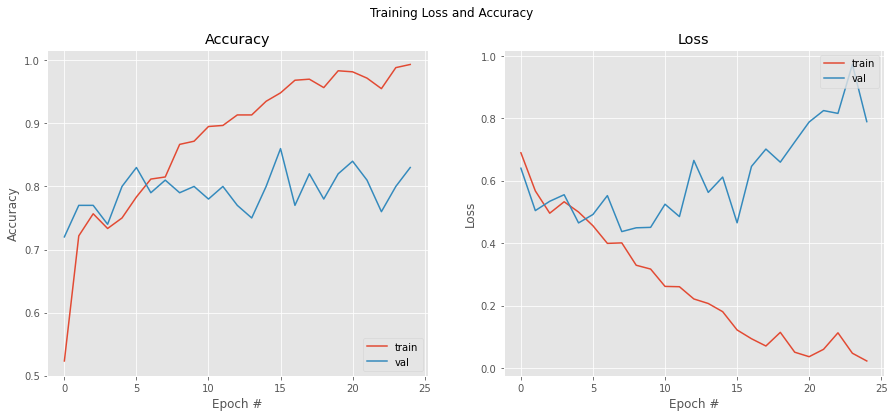

In [ ]:
plot_prediction(n_epochs, mfit_1) 


Observamos que la accuracy va subiendo más rápidamente en los primeros epochs y luego sigue creciendo aunque más lentamente. No se obtiene una línea plana o decreciente al final lo que indica que no hay overfitting aunque si podría haberlo si se siguiera entrenando. 

#### Modelo 2: 

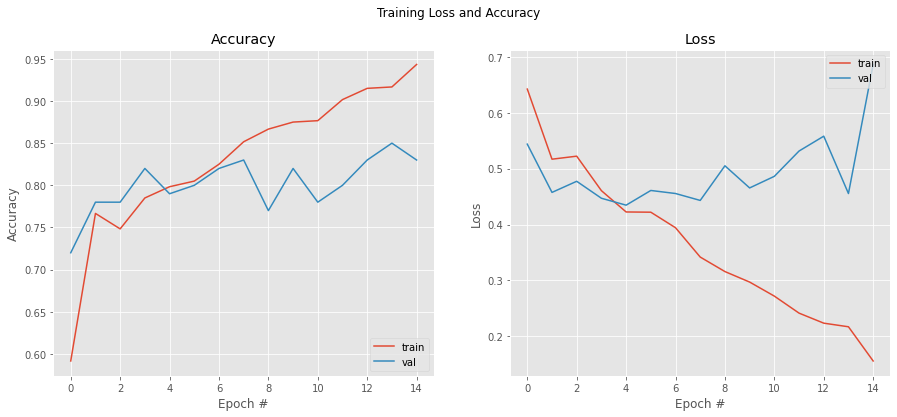

In [ ]:
plot_prediction(n_epochs, mfit_2) 


Observamos que la accuracy de este modelo es buena, aunque existe un punto en la gráfica en la que se estanca el train y baja la val a partir del cual se podría decir que hay overfitting. Esto se podría mejorar entrenando con más datos, regularización, validación cruzada, etc. 

Comprobamos con los datos de test que son datos que el modelo no ha visto antes para obtener la accuracy real de los modelos. 

In [ ]:
eval_m1 = model_1.evaluate(x_test, y_test, verbose=0)

eval_m2 = model_2.evaluate(x_test, y_test, verbose=0)

print("Evaluación del modelo 1: Test loss, Test accuracy:", eval_m1)
print("Evaluación del modelo 2: Test loss, Test accuracy:", eval_m2)

Evaluación del modelo 1: Test loss, Test accuracy: [0.7891781330108643, 0.8299999833106995]
Evaluación del modelo 2: Test loss, Test accuracy: [0.6864421367645264, 0.8299999833106995]


Observamos que la accuracy de ambos modelos es la misma 83%, se considera que debe ser del 80% o superior para que el modelo sea aceptable. 

En lo que difieren es en el loss osea la pérdida de aciertos que en el modelo 1 tiene un 79% y el modelo 2 mejora con un 69%. 

Procedemos a realizar una predicción.

In [ ]:
y_prediction_m1 = model_1.predict(x_test)

4/4 [==============================] - 0s 4ms/step


In [ ]:
y_prediction_m1[1:10]

array([[3.7088146e-05, 9.9992323e-01],
       [9.9922025e-01, 7.6926802e-04],
       [1.5311708e-01, 8.3350319e-01],
       [9.5880127e-01, 8.4013045e-02],
       [1.2110150e-01, 9.2366272e-01],
       [1.9521882e-01, 7.7077746e-01],
       [9.3558252e-01, 1.1989833e-02],
       [1.5671518e-02, 9.3200117e-01],
       [9.8141313e-01, 3.2691658e-03]], dtype=float32)

In [ ]:
y_prediction_m2 = model_2.predict(x_test)

4/4 [==============================] - 0s 4ms/step


In [ ]:
y_prediction_m2[1:10]

array([[8.3003403e-04, 9.9999952e-01],
       [9.0753406e-01, 1.8403703e-02],
       [3.9298221e-01, 4.6139228e-01],
       [3.6908749e-01, 5.4143512e-01],
       [1.0509948e-01, 9.8694211e-01],
       [5.1042897e-01, 4.2323709e-01],
       [9.1295385e-01, 3.7409134e-02],
       [3.2044128e-02, 9.9827349e-01],
       [7.4992764e-01, 1.8345974e-01]], dtype=float32)

#### Referencia: 

https://www.v7labs.com/blog/overfitting

Referencias:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

https://github.com/keras-team/keras/blob/v2.11.0/keras/layers/convolutional/conv2d.py#L29-L198

https://github.com/keras-team/keras/blob/v2.11.0/keras/utils/image_dataset.py#L30-L323

https://stackoverflow.com/questions/51348085/keras-tutorial-error-nameerror-name-layers-is-not-defined

https://github.com/keras-team/keras/blob/v2.11.0/keras/losses.py#L947-L1032

https://keras.io/api/callbacks/reduce_lr_on_plateau/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

https://github.com/keras-team/keras/blob/v2.11.0/keras/callbacks.py#L2905-L3042

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

### Salida del pdf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
%cd drive/My\ Drive/ # called magic code

/content/drive/My Drive


In [ ]:
%cd Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [7]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscri

In [10]:
!jupyter nbconvert --to html PEC2.ipynb

[NbConvertApp] Converting notebook PEC2.ipynb to html
[NbConvertApp] Writing 768714 bytes to PEC2.html


In [11]:
!jupyter nbconvert --to pdf PEC2.ipynb

[NbConvertApp] Converting notebook PEC2.ipynb to pdf
[NbConvertApp] Support files will be in PEC2_files/
[NbConvertApp] Making directory ./PEC2_files
[NbConvertApp] Making directory ./PEC2_files
[NbConvertApp] Making directory ./PEC2_files
[NbConvertApp] Making directory ./PEC2_files
[NbConvertApp] Making directory ./PEC2_files
[NbConvertApp] Making directory ./PEC2_files
[NbConvertApp] Writing 153359 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: ['xelatex', './notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/